In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/AI-Interview/train.csv')
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# Handle missing values
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')

print("--- Initial Data Inspection and Null Count ---")
print(df.head())
print("\nNull Values Handled. Current Null Count:")
print(df.isnull().sum())

--- Initial Data Inspection and Null Count ---
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  

Null Values Handled. Current Null Count:
id              0
qid1            0
qid2            0
question1 


--- Target Variable Distribution ---
is_duplicate
0    255045
1    149306
Name: count, dtype: int64


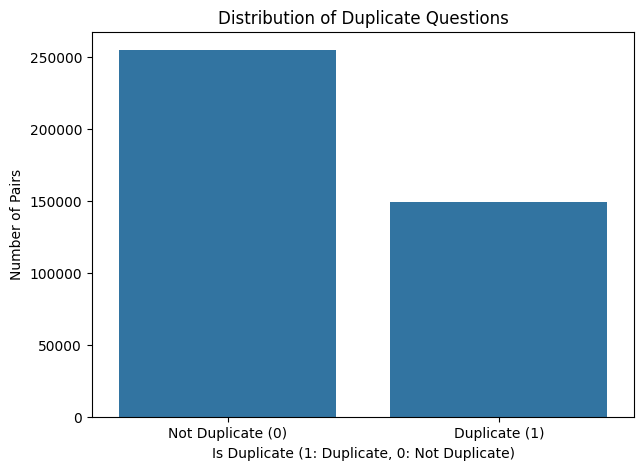

In [6]:
#Target Variable Distribution

print("\n--- Target Variable Distribution ---")
duplicate_counts = df['is_duplicate'].value_counts()
print(duplicate_counts)

# Visualize the distribution
plt.figure(figsize=(7, 5))
sns.barplot(x=duplicate_counts.index, y=duplicate_counts.values)
plt.title('Distribution of Duplicate Questions')
plt.xlabel('Is Duplicate (1: Duplicate, 0: Not Duplicate)')
plt.ylabel('Number of Pairs')
plt.xticks([0, 1], ['Not Duplicate (0)', 'Duplicate (1)'])
plt.savefig('eda_duplicate_distribution.png')
plt.show()
plt.close()

In [7]:

#Feature Engineering for EDA (Length and Word Counts)

df['q1_len'] = df['question1'].apply(lambda x: len(str(x)))
df['q2_len'] = df['question2'].apply(lambda x: len(str(x)))
df['q1_word_count'] = df['question1'].apply(lambda x: len(str(x).split()))
df['q2_word_count'] = df['question2'].apply(lambda x: len(str(x).split()))

# The difference in word count is a strong simple feature
df['word_count_diff'] = np.abs(df['q1_word_count'] - df['q2_word_count'])

print("\n--- Descriptive Statistics of Length Features ---")
print(df[['q1_len', 'q2_len', 'q1_word_count', 'q2_word_count', 'word_count_diff']].describe())


--- Descriptive Statistics of Length Features ---
              q1_len         q2_len  q1_word_count  q2_word_count  \
count  404351.000000  404351.000000  404351.000000  404351.000000   
mean       59.533598      60.102883      10.941771      11.181125   
std        29.939203      33.864489       5.428721       6.305352   
min         0.000000       0.000000       0.000000       0.000000   
25%        39.000000      39.000000       7.000000       7.000000   
50%        52.000000      51.000000      10.000000      10.000000   
75%        72.000000      72.000000      13.000000      13.000000   
max       623.000000    1169.000000     125.000000     237.000000   

       word_count_diff  
count    404351.000000  
mean          3.693610  
std           4.833433  
min           0.000000  
25%           1.000000  
50%           2.000000  
75%           5.000000  
max         223.000000  


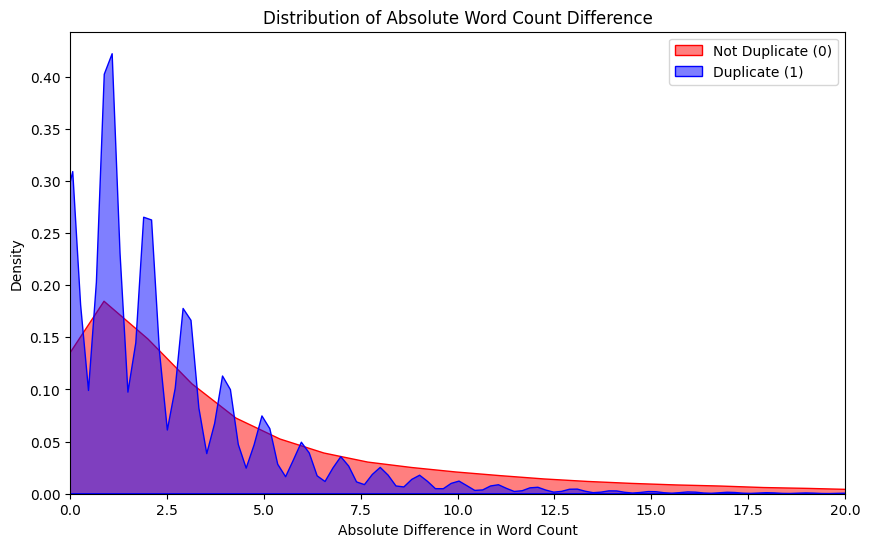

In [8]:
# Visualize Key Feature Distribution by Target Variable
# Visualize the distribution of the absolute difference in word count
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['is_duplicate'] == 0]['word_count_diff'], label='Not Duplicate (0)', color='red', fill=True, alpha=0.5)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_count_diff'], label='Duplicate (1)', color='blue', fill=True, alpha=0.5)
plt.title('Distribution of Absolute Word Count Difference')
plt.xlabel('Absolute Difference in Word Count')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 20)
plt.savefig('eda_word_count_diff_distribution.png')
plt.show()
plt.close()

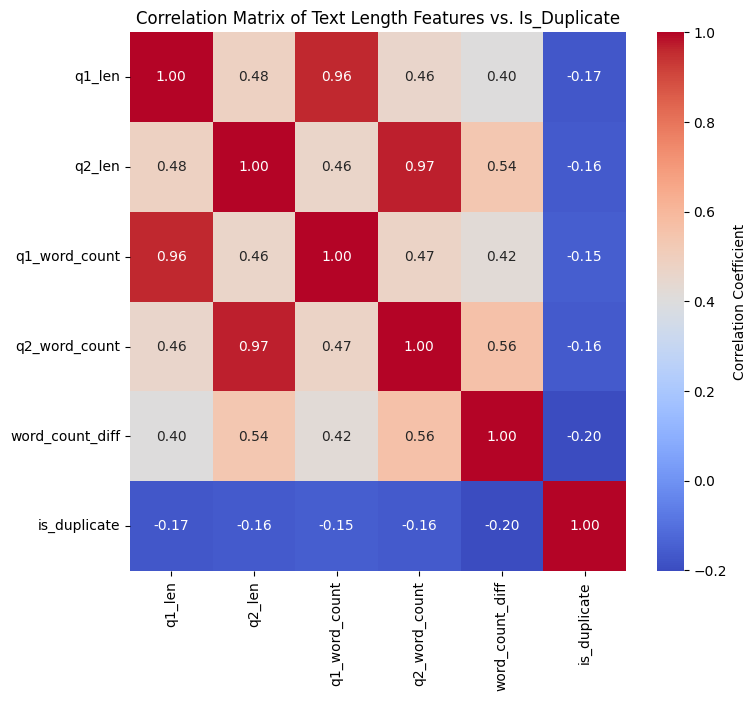

In [9]:
# 5. Correlation Analysis ---

correlation_features = ['q1_len', 'q2_len', 'q1_word_count', 'q2_word_count', 'word_count_diff', 'is_duplicate']
corr_matrix = df[correlation_features].corr()


plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Text Length Features vs. Is_Duplicate')
plt.savefig('eda_correlation_matrix.png')
plt.show()
plt.close()


In [10]:
STOP_WORDS = set(['the', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 'just', 'don', 'should', 'now', 'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'which', 'who', 'whom', 'this', 'that', 'these', 'those'])

In [11]:
# Define preprocessing for text visualization
def preprocess_for_wc(text):
    """Clean, normalize, and remove stopwords from text for Word Cloud/Counts."""
    text = str(text).lower()
    # Remove math tags and non-alphanumeric characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in STOP_WORDS)
    return text


df['q1_cleaned'] = df['question1'].apply(preprocess_for_wc)
df['q2_cleaned'] = df['question2'].apply(preprocess_for_wc)



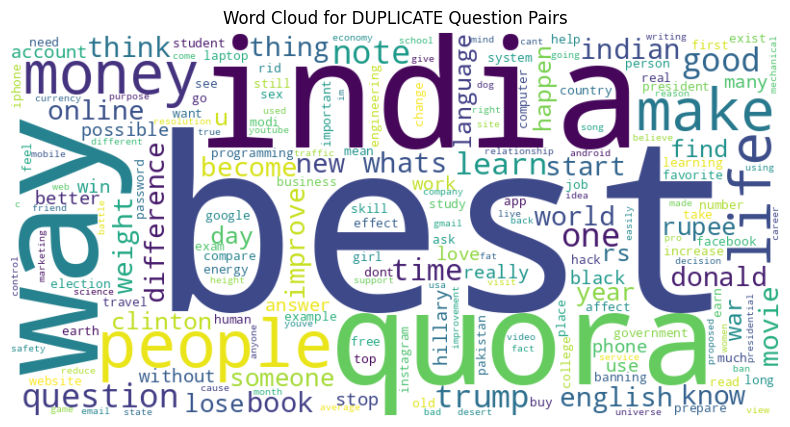

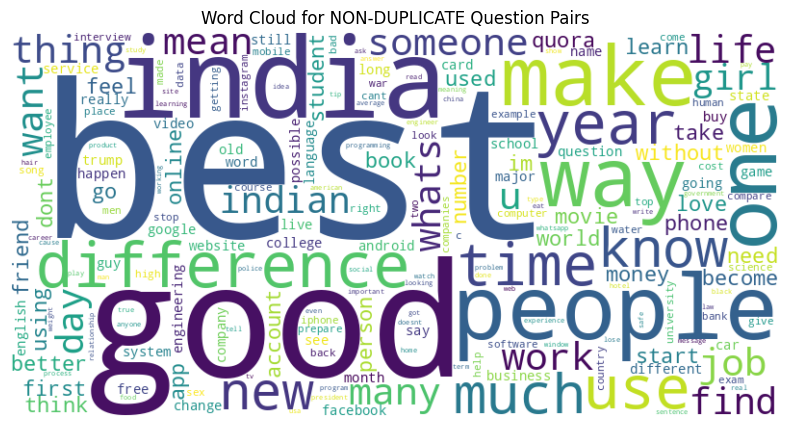

In [12]:

#  Word Cloud Analysis (Separated by is_duplicate)

# Combine text for Duplicates (is_duplicate = 1)
dup_text = ' '.join(df[df['is_duplicate'] == 1]['q1_cleaned'].tolist() +
                    df[df['is_duplicate'] == 1]['q2_cleaned'].tolist())

# Combine text for Non-Duplicates (is_duplicate = 0)
non_dup_text = ' '.join(df[df['is_duplicate'] == 0]['q1_cleaned'].tolist() +
                        df[df['is_duplicate'] == 0]['q2_cleaned'].tolist())

#duplicate
wordcloud_dup = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(dup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_dup, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for DUPLICATE Question Pairs')
plt.savefig('eda_wordcloud_duplicates.png')
plt.show()
plt.close()

#non-dplicate
wordcloud_non_dup = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(non_dup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_dup, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for NON-DUPLICATE Question Pairs')
plt.savefig('eda_wordcloud_non_duplicates.png')
plt.show()
plt.close()


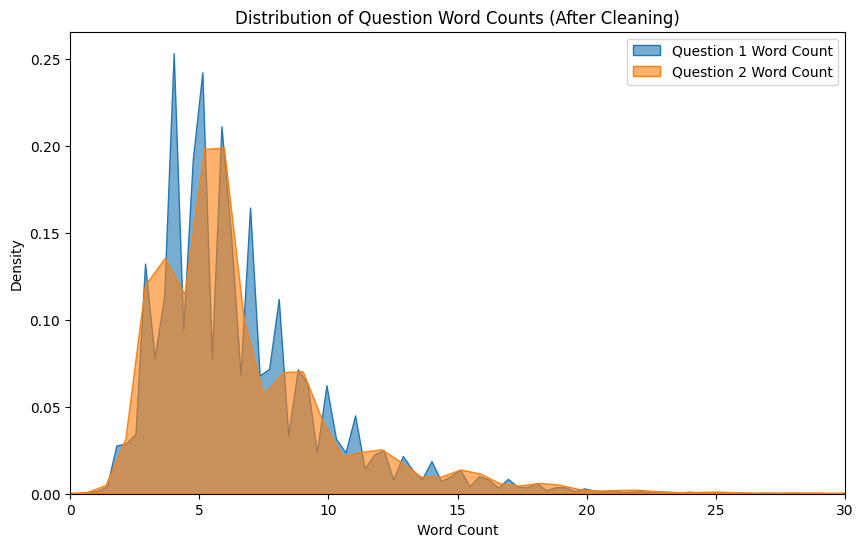

In [13]:
#  Sentence Length Visualization (Word Count)

df['q1_word_count'] = df['q1_cleaned'].apply(lambda x: len(x.split()))
df['q2_word_count'] = df['q2_cleaned'].apply(lambda x: len(x.split()))

# Plot for the distribution of word counts for Q1 and Q2
plt.figure(figsize=(10, 6))
sns.kdeplot(df['q1_word_count'], label='Question 1 Word Count', fill=True, alpha=0.6)
sns.kdeplot(df['q2_word_count'], label='Question 2 Word Count', fill=True, alpha=0.6)
plt.title('Distribution of Question Word Counts (After Cleaning)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 30)
plt.savefig('eda_sentence_length_distribution.png')
plt.show()
plt.close()



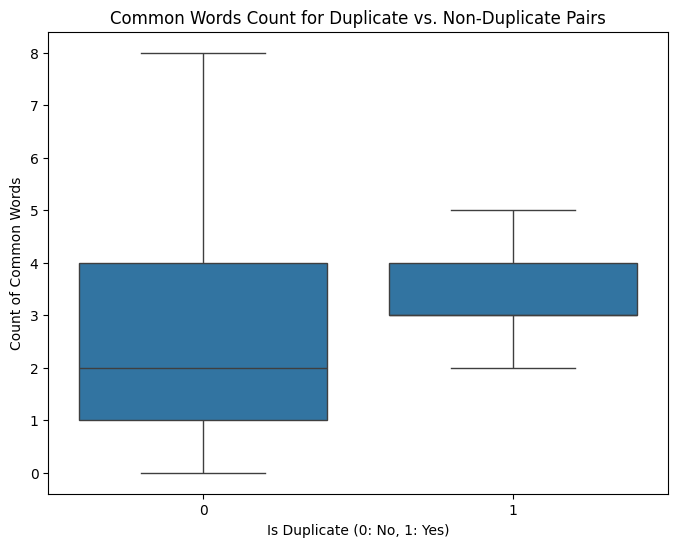

In [14]:

# Common Word Analysis (Feature Comparison)

def count_common_words(row):
    """Count the number of common words between two questions."""
    q1_words = set(row['q1_cleaned'].split())
    q2_words = set(row['q2_cleaned'].split())
    return len(q1_words.intersection(q2_words))

df['common_words'] = df.apply(count_common_words, axis=1)

# Visualize the common words count
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_duplicate', y='common_words', data=df, showfliers=False)
plt.title('Common Words Count for Duplicate vs. Non-Duplicate Pairs')
plt.xlabel('Is Duplicate (0: No, 1: Yes)')
plt.ylabel('Count of Common Words')
plt.savefig('eda_common_words_boxplot.png')
plt.show()
plt.close()

--- Correlation Matrix of Length/Count Features ---
                   q1_len    q2_len  q1_word_count  q2_word_count  \
q1_len           1.000000  0.484703       0.958026       0.458832   
q2_len           0.484703  1.000000       0.461897       0.967578   
q1_word_count    0.958026  0.461897       1.000000       0.471529   
q2_word_count    0.458832  0.967578       0.471529       1.000000   
word_count_diff  0.402516  0.537767       0.421927       0.563191   
is_duplicate    -0.171125 -0.161950      -0.154284      -0.160401   

                 word_count_diff  is_duplicate  
q1_len                  0.402516     -0.171125  
q2_len                  0.537767     -0.161950  
q1_word_count           0.421927     -0.154284  
q2_word_count           0.563191     -0.160401  
word_count_diff         1.000000     -0.201516  
is_duplicate           -0.201516      1.000000  


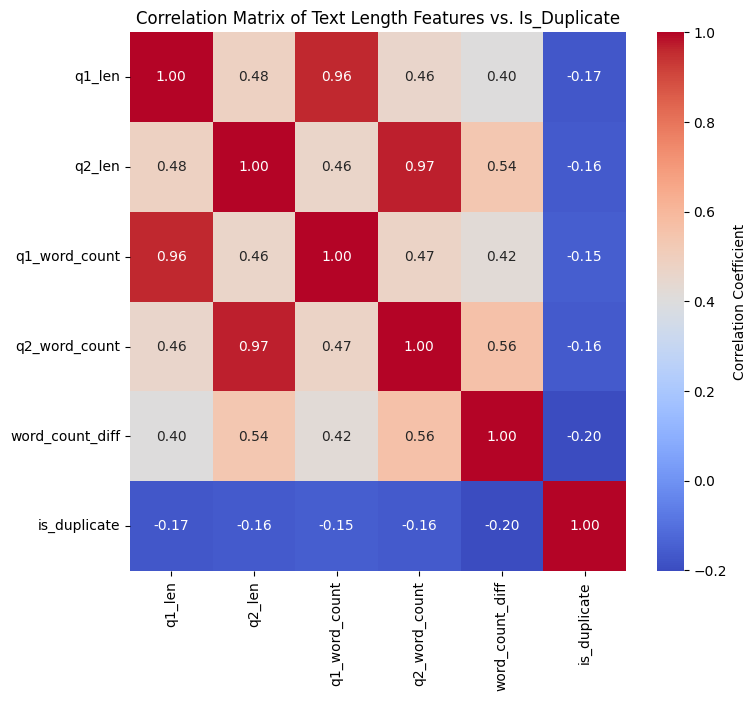

In [15]:
# Feature Engineering (Length and Word Counts

df['q1_len'] = df['question1'].apply(lambda x: len(str(x)))
df['q2_len'] = df['question2'].apply(lambda x: len(str(x)))

# Word Count
df['q1_word_count'] = df['question1'].apply(lambda x: len(str(x).split()))
df['q2_word_count'] = df['question2'].apply(lambda x: len(str(x).split()))

# Difference in Word Count (A highly predictive feature)
df['word_count_diff'] = np.abs(df['q1_word_count'] - df['q2_word_count'])

# Correlation Analysis
correlation_features = ['q1_len', 'q2_len', 'q1_word_count', 'q2_word_count', 'word_count_diff', 'is_duplicate']
corr_matrix = df[correlation_features].corr()

print("--- Correlation Matrix of Length/Count Features ---")
print(corr_matrix)

# correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Text Length Features vs. Is_Duplicate')
plt.savefig('eda_correlation_analysis.png')
plt.show()
plt.close()

In [16]:
# Check for nulls
print("\nChecking for Missing Values:")
print(df.isnull().sum())

df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')


Checking for Missing Values:
id                 0
qid1               0
qid2               0
question1          0
question2          0
is_duplicate       0
q1_len             0
q2_len             0
q1_word_count      0
q2_word_count      0
word_count_diff    0
q1_cleaned         0
q2_cleaned         0
common_words       0
dtype: int64


#Text Pre-processing

In [29]:
# In a separate Colab cell before running the main code:
!pip install imbalanced-learn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler # For Oversampling

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [30]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

In [31]:
def preprocess_and_lemmatize(text):
    """Clean, normalize, remove stopwords, and lemmatize text."""
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text) # Remove HTML/Math tags
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove punctuation/special characters

    words = text.split()

    # Remove stopwords and apply Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in STOP_WORDS]

    return ' '.join(words)
df['q1_cleaned'] = df['question1'].apply(preprocess_and_lemmatize)
df['q2_cleaned'] = df['question2'].apply(preprocess_and_lemmatize)

print("--- Text Cleaning & Lemmatization Applied (Sample) ---")
print(df[['question1', 'q1_cleaned', 'q2_cleaned']].head())

--- Text Cleaning & Lemmatization Applied (Sample) ---
                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                          q1_cleaned  \
0     what step step guide invest share market india   
1               what story kohinoor kohinoor diamond   
2  i increase speed my internet connection using vpn   
3                       i mentally lonely i solve it   
4  one dissolve water quikly sugar salt methane c...   

                                          q2_cleaned  
0           what step step guide invest share market  
1  what would happen indian government stole kohi...  
2               internet speed increased hacking dns  
3           find remainder math2324math divided 242

In [32]:
# Feature Engineering
def count_common_words(row):
    q1_words = set(row['q1_cleaned'].split())
    q2_words = set(row['q2_cleaned'].split())
    return len(q1_words.intersection(q2_words))

df['common_words'] = df.apply(count_common_words, axis=1)
df['q1_word_count'] = df['q1_cleaned'].apply(lambda x: len(x.split()))
df['q2_word_count'] = df['q2_cleaned'].apply(lambda x: len(x.split()))
df['word_count_diff'] = np.abs(df['q1_word_count'] - df['q2_word_count'])

In [33]:
# Vectorization (TF-IDF)
print("\n--- TF-IDF Vectorization & Feature Matrix Creation ---")

corpus = df['q1_cleaned'].tolist() + df['q2_cleaned'].tolist()
tfidf = TfidfVectorizer(max_features=20000)
tfidf.fit(corpus)

q1_vec = tfidf.transform(df['q1_cleaned'])
q2_vec = tfidf.transform(df['q2_cleaned'])

# Combine TF-IDF vectors with engineered features
X_interaction = np.abs(q1_vec - q2_vec)
X_product = q1_vec.multiply(q2_vec)

numerical_features = df[['common_words', 'word_count_diff']].values
X = hstack([X_interaction, X_product, numerical_features]).tocsr()
y = df['is_duplicate']

print(f"Final Feature Matrix Shape: {X.shape}")


--- TF-IDF Vectorization & Feature Matrix Creation ---
Final Feature Matrix Shape: (404351, 40002)


In [34]:
# Data Splitting (70% Train, 10% Validation, 20% Test)
# Split into Test (20%) and Train/Validation (80%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split Train/Validation (80%) into Train (70/80 = 87.5%) and Validation (10/80 = 12.5%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.10 / 0.80), random_state=42, stratify=y_train_val
)

print(f"\n--- Data Split (70/10/20) ---")
print(f"Training Set Size (70%): {X_train.shape[0]} rows")
print(f"Validation Set Size (10%): {X_val.shape[0]} rows")
print(f"Testing Set Size (20%): {X_test.shape[0]} rows")


--- Data Split (70/10/20) ---
Training Set Size (70%): 283045 rows
Validation Set Size (10%): 40435 rows
Testing Set Size (20%): 80871 rows


In [35]:
# Oversampling Duplicates (Applied to TRAINING Data Only)
print("\n--- Applying Oversampling to Training Data ---")

# Apply RandomOverSampler to the training set only (X_train, y_train)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f"Original Training Duplicates (1): {y_train.sum()}")
print(f"Resampled Training Duplicates (1): {y_train_resampled.sum()}")
print(f"Resampled Training Total Size: {X_train_resampled.shape[0]} rows")
print("Data is now ready for Step 3: Model Building.")


--- Applying Oversampling to Training Data ---
Original Training Duplicates (1): 104514
Resampled Training Duplicates (1): 178531
Resampled Training Total Size: 357062 rows
Data is now ready for Step 3: Model Building.


#Model Training

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from scipy.sparse import csr_matrix # Ensure X_val is in the correct format

print("--- Training Logistic Regression Baseline ---")

# Convert resampled data to the expected sparse format (if not already)
X_train_sparse = X_train_resampled.tocsr()

# Initialize and Train Model
logreg = LogisticRegression(solver='liblinear', C=1.0, random_state=42, class_weight='balanced', max_iter=100)
logreg.fit(X_train_sparse, y_train_resampled)

# Evaluation on Validation Set
y_val_pred = logreg.predict(X_val)
y_val_proba = logreg.predict_proba(X_val)[:, 1]

f1_logreg = f1_score(y_val, y_val_pred)
auc_logreg = roc_auc_score(y_val, y_val_proba)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Logistic Regression Validation F1-Score: {f1_logreg:.4f}")
print(f"Logistic Regression Validation AUC-ROC: {auc_logreg:.4f}")
print(f"Logistic Regression Validation Accuracy: {val_accuracy:.4f}")
print("--------------------------------------------------")

--- Training Logistic Regression Baseline ---
Logistic Regression Validation F1-Score: 0.7500
Logistic Regression Validation AUC-ROC: 0.8842
Logistic Regression Validation Accuracy: 0.7977
--------------------------------------------------


In [37]:
# Evaluation on Test Set
y_test_pred = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)[:, 1]

f1_logreg_test = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Logistic Regression Test Results:")
print(f"Logistic Regression Test Precision: {test_precision:.4f}")
print(f"Logistic Regression Test Recall: {test_recall:.4f}")
print(f"Logistic Regression Test AUC-ROC: {test_auc:.4f}")
print(f"Logistic Regression Test F1-Score: {f1_logreg_test:.4f}")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")

Logistic Regression Test Results:
Logistic Regression Test Precision: 0.6902
Logistic Regression Test Recall: 0.8233
Logistic Regression Test AUC-ROC: 0.8834
Logistic Regression Test F1-Score: 0.7509
Logistic Regression Test Accuracy: 0.7983



--- Plotting Confusion Matrix ---


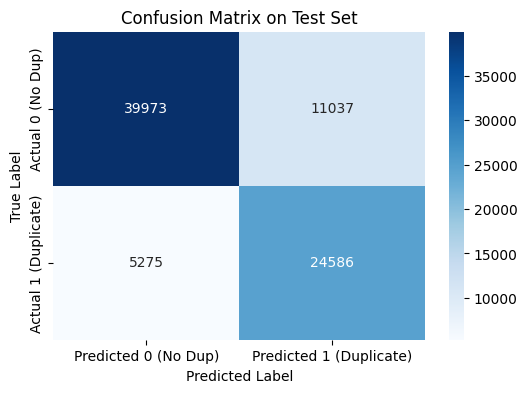

Saved: evaluation_confusion_matrix.png

--- Plotting AUC-ROC Curve ---


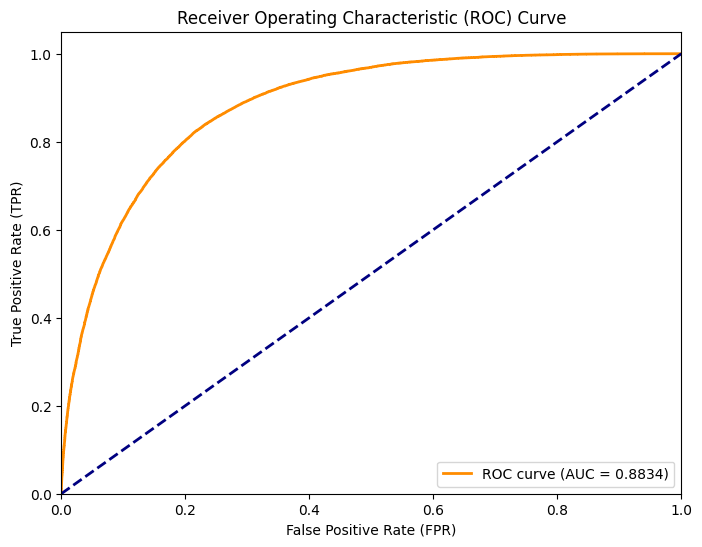

Saved: evaluation_roc_curve.png

Evaluation complete. Your final performance metrics are reported above.


In [39]:
# --- 3. Plot Confusion Matrix ---
print("\n--- Plotting Confusion Matrix ---")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No Dup)', 'Predicted 1 (Duplicate)'],
            yticklabels=['Actual 0 (No Dup)', 'Actual 1 (Duplicate)'])
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('evaluation_confusion_matrix.png')
plt.show()
plt.close()
print("Saved: evaluation_confusion_matrix.png")

# --- 4. Plot AUC-ROC Curve ---
print("\n--- Plotting AUC-ROC Curve ---")

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('evaluation_roc_curve.png')
plt.show()
plt.close()
print("Saved: evaluation_roc_curve.png")

print("\nEvaluation complete. Your final performance metrics are reported above.")

**Sequence data prepprocessing**

In [4]:
!pip install imbalanced-learn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# --- Hyperparameters ---
MAX_WORDS = 30000          # Vocabulary size for the embedding layer
MAX_SEQUENCE_LENGTH = 30   # Max length to pad sequences (questions longer than 30 words are truncated)

In [7]:
# --- 1. Setup and Preprocessing Functions ---
STOP_WORDS = set(['the', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 'just', 'don', 'should', 'now', 'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'which', 'who', 'whom', 'this', 'that', 'these', 'those'])
lemmatizer = WordNetLemmatizer()

In [8]:
# Load the dataset
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
y = df['is_duplicate'] # Target variable

In [9]:
def preprocess_and_lemmatize(text):
    """Clean, normalize, remove stopwords, and lemmatize text."""
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in STOP_WORDS]

    return ' '.join(words)

In [10]:

df['q1_cleaned'] = df['question1'].apply(preprocess_and_lemmatize)
df['q2_cleaned'] = df['question2'].apply(preprocess_and_lemmatize)


In [11]:
# Tokenization and Padding (Sequence Modeling Inputs)
print("--- Sequence Tokenization & Padding ---")

# Fit Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
all_questions = df['q1_cleaned'].tolist() + df['q2_cleaned'].tolist()
tokenizer.fit_on_texts(all_questions)

#  Convert text to sequences of integers
sequences_q1 = tokenizer.texts_to_sequences(df['q1_cleaned'])
sequences_q2 = tokenizer.texts_to_sequences(df['q2_cleaned'])

# 2c. Pad sequences to fixed length (MAX_SEQUENCE_LENGTH)
padded_q1 = pad_sequences(sequences_q1, maxlen=MAX_SEQUENCE_LENGTH)
padded_q2 = pad_sequences(sequences_q2, maxlen=MAX_SEQUENCE_LENGTH)

# 2d. Stack the sequences into a single array for splitting
X_sequence = np.stack([padded_q1, padded_q2], axis=1) # Shape (N, 2, MAX_LENGTH)

print(f"Padded Sequences Shape: {X_sequence.shape}")

--- Sequence Tokenization & Padding ---
Padded Sequences Shape: (404351, 2, 30)


In [12]:
# --- 3. Data Splitting (70% Train, 10% Validation, 20% Test) ---
print("\n--- Data Splitting (70/10/20) ---")

# Step 3a: Split into Test (20%) and Train/Validation (80%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_sequence, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3b: Split Train/Validation (80%) into Train (70/80 = 87.5%) and Validation (10/80 = 12.5%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.10 / 0.80), random_state=42, stratify=y_train_val
)


--- Data Splitting (70/10/20) ---


In [13]:
# Separate the Q1 and Q2 arrays for the Siamese inputs
X_train_q1 = X_train[:, 0]
X_train_q2 = X_train[:, 1]
X_val_q1 = X_val[:, 0]
X_val_q2 = X_val[:, 1]
X_test_q1 = X_test[:, 0]
X_test_q2 = X_test[:, 1]

print(f"Training Set Size (70%): {X_train.shape[0]} rows")
print(f"Validation Set Size (10%): {X_val.shape[0]} rows")
print(f"Testing Set Size (20%): {X_test.shape[0]} rows")


Training Set Size (70%): 283045 rows
Validation Set Size (10%): 40435 rows
Testing Set Size (20%): 80871 rows


In [14]:
# Oversampling Duplicates (Applied to TRAINING Data Only)
print("\n--- Applying Oversampling to Training Data ---")

X_train_stacked = np.hstack([X_train_q1, X_train_q2])

# Apply RandomOverSampler to the stacked training set
ros = RandomOverSampler(random_state=42)
X_train_resampled_stacked, y_train_resampled = ros.fit_resample(X_train_stacked, y_train)

# Unstack the resampled arrays back into Q1 and Q2 inputs
half_dim = X_train_resampled_stacked.shape[1] // 2
X_train_q1_resampled = X_train_resampled_stacked[:, :half_dim]
X_train_q2_resampled = X_train_resampled_stacked[:, half_dim:]


--- Applying Oversampling to Training Data ---


In [15]:
print(f"Original Training Duplicates (1): {y_train.sum()}")
print(f"Resampled Training Duplicates (1): {y_train_resampled.sum()}")
print(f"Resampled Training Total Size: {X_train_resampled_stacked.shape[0]} rows")
print("\nData is now ready for Step 3: Siamese LSTM/GRU Model Building.")

Original Training Duplicates (1): 104514
Resampled Training Duplicates (1): 178531
Resampled Training Total Size: 357062 rows

Data is now ready for Step 3: Siamese LSTM/GRU Model Building.


**Sequence model**

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Lambda, Subtract, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.optimizers import Adam
import numpy as np


In [51]:

EMBEDDING_DIM = 100
MAX_WORDS = 30000
MAX_SEQUENCE_LENGTH = 30
custom_optimizer = Adam(learning_rate=0.001)
EPOCHS = 3


**ANN+GRU**

In [58]:
print("--- Training Siamese GRU Network ---")

input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_sequence')
# Layer 1: Embedding - Maps integer tokens to dense vectors
embedding = Embedding(
    input_dim=MAX_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(input_sequence)

# Layer 2: GRU - Processes the word sequence to output a single
gru_output = GRU(128, activation='relu')(embedding)

# Shared Model object
shared_model = Model(inputs=input_sequence, outputs=gru_output)

# Define the Two Input Heads
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q1')
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q2')

# Process Inputs with the Shared Model
processed_q1 = shared_model(input_q1)
processed_q2 = shared_model(input_q2)

# Define the Comparison Layer (The "Head")
# We use the Manhattan Distance (L1 norm) to measure similarity.
distance = Lambda(lambda x: K.abs(x[0] - x[1]), name='distance_layer')([processed_q1, processed_q2])

# Final Classification Layer (1 unit, sigmoid for binary probability)
output = Dense(1, activation='sigmoid', name='output_layer')(distance)

# Build and Compile the Final Model
siamese_model_GRU = Model(inputs=[input_q1, input_q2], outputs=output)
siamese_model_GRU.compile(
    optimizer=custom_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# siamese_model.summary() # Uncomment to see the network architecture

#  Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

# Train the Model
history = siamese_model_GRU.fit(
    x={'input_q1': X_train_q1_resampled, 'input_q2': X_train_q2_resampled}, # Use resampled data
    y=y_train_resampled,
    validation_data=({'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val),
    epochs=EPOCHS,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on Validation Set
print("\n--- Siamese GRU Validation Performance ---")


val_loss, val_acc, val_auc = siamese_model_GRU.evaluate(
    {'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val, verbose=0
)


y_val_proba = siamese_model_GRU.predict({'input_q1': X_val_q1, 'input_q2': X_val_q2}).flatten()
y_val_pred = (y_val_proba > 0.5).astype(int)
f1_ann = f1_score(y_val, y_val_pred)

print(f"ANN Validation Accuracy: {val_acc:.4f}")
print(f"ANN Validation AUC-ROC: {val_auc:.4f}")
print(f"ANN Validation F1-Score: {f1_ann:.4f}")


--- Training Siamese GRU Network ---
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


698/698 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.6178 - auc: 0.7261 - loss: 0.6380 - val_accuracy: 0.7488 - val_auc: 0.8185 - val_loss: 0.5224
Epoch 2/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7939 - auc: 0.8675 - loss: 0.4599 - val_accuracy: 0.7792 - val_auc: 0.8528 - val_loss: 0.4673
Epoch 3/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8516 - auc: 0.9225 - loss: 0.3497 - val_accuracy: 0.7771 - val_auc: 0.8595 - val_loss: 0.4716

--- Siamese GRU Validation Performance ---
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
ANN Validation Accuracy: 0.7792
ANN Validation AUC-ROC: 0.8528
ANN Validation F1-Score: 0.7193


*ANN+LSTM*

In [55]:
print("--- Training Siamese LSTM Network ---")



input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_sequence')

embedding = Embedding(
    input_dim=MAX_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True # Allow embedding weights to be learned
)(input_sequence)

# Layer 2: LSTM - Processes the word sequence to output a single, fixed-size vector

lstm_output = LSTM(128, activation='relu')(embedding)

# Shared Model object
shared_model = Model(inputs=input_sequence, outputs=lstm_output)


input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q1')
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q2')

# Process Inputs
processed_q1 = shared_model(input_q1)
processed_q2 = shared_model(input_q2)

#Comparison Layer

distance = Lambda(lambda x: K.abs(x[0] - x[1]), name='distance_layer')([processed_q1, processed_q2])

# Final Classification Layer (1 unit, sigmoid for binary probability)
output = Dense(1, activation='sigmoid', name='output_layer')(distance)


siamese_model_lstm = Model(inputs=[input_q1, input_q2], outputs=output)
siamese_model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

#  Train the Model

history = siamese_model_lstm.fit(
    x={'input_q1': X_train_q1_resampled, 'input_q2': X_train_q2_resampled},
    y=y_train_resampled,
    validation_data=({'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val),
    epochs=EPOCHS,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on Validation Set
print("\n--- Siamese LSTM Validation Performance ---")


val_loss, val_acc, val_auc = siamese_model_lstm.evaluate(
    {'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val, verbose=0
)


y_val_proba = siamese_model_lstm.predict({'input_q1': X_val_q1, 'input_q2': X_val_q2}).flatten()
y_val_pred = (y_val_proba > 0.5).astype(int)
f1_ann = f1_score(y_val, y_val_pred)

print(f"ANN (LSTM) Validation Accuracy: {val_acc:.4f}")
print(f"ANN (LSTM) Validation AUC-ROC: {val_auc:.4f}")
print(f"ANN (LSTM) Validation F1-Score: {f1_ann:.4f}")


--- Training Siamese LSTM Network ---
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


698/698 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6300 - auc: 0.7252 - loss: 0.6267 - val_accuracy: 0.7485 - val_auc: 0.8298 - val_loss: 0.5088
Epoch 2/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8095 - auc: 0.8846 - loss: 0.4297 - val_accuracy: 0.7879 - val_auc: 0.8645 - val_loss: 0.4503
Epoch 3/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8590 - auc: 0.9284 - loss: 0.3363 - val_accuracy: 0.7938 - val_auc: 0.8705 - val_loss: 0.4600

--- Siamese LSTM Validation Performance ---
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
ANN (LSTM) Validation Accuracy: 0.7879
ANN (LSTM) Validation AUC-ROC: 0.8645
ANN (LSTM) Validation F1-Score: 0.7295


**ANN+LSTM+GRU**

In [53]:
print("--- Training Stacked Siamese LSTM-GRU Network ---")

# 1. Define the Shared Sequence Processor (The "Siamese Branch")

input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_sequence')
# Layer 1: Embedding
embedding = Embedding(
    input_dim=MAX_WORDS,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)(input_sequence)

# Layer 2: LSTM
lstm_output = LSTM(128, activation='relu', return_sequences=True)(embedding)

# Layer 3: GRU (Final recurrent layer, outputs a single vector)
gru_output = GRU(128, activation='relu')(lstm_output)

shared_model = Model(inputs=input_sequence, outputs=gru_output)


input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q1')
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_q2')

# Process Inputs with the Shared Model
processed_q1 = shared_model(input_q1)
processed_q2 = shared_model(input_q2)

#  Define the Comparison Layer (Manhattan Distance)
distance = Lambda(lambda x: K.abs(x[0] - x[1]), name='distance_layer')([processed_q1, processed_q2])

# Final Classification Layer
output = Dense(1, activation='sigmoid', name='output_layer')(distance)

siamese_model_stacked = Model(inputs=[input_q1, input_q2], outputs=output)
siamese_model_stacked.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

l

history = siamese_model_stacked.fit(
    x={'input_q1': X_train_q1_resampled, 'input_q2': X_train_q2_resampled},
    y=y_train_resampled,
    validation_data=({'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val),
    epochs=EPOCHS,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)


print("\n--- Stacked Siamese LSTM-GRU Validation Performance ---")


val_loss, val_acc, val_auc = siamese_model_stacked.evaluate(
    {'input_q1': X_val_q1, 'input_q2': X_val_q2}, y_val, verbose=0
)


y_val_proba = siamese_model_stacked.predict({'input_q1': X_val_q1, 'input_q2': X_val_q2}).flatten()
y_val_pred = (y_val_proba > 0.5).astype(int)
f1_ann = f1_score(y_val, y_val_pred)

print(f"ANN (LSTM-GRU) Validation Accuracy: {val_acc:.4f}")
print(f"ANN (LSTM-GRU) Validation AUC-ROC: {val_auc:.4f}")
print(f"ANN (LSTM-GRU) Validation F1-Score: {f1_ann:.4f}")

--- Training Stacked Siamese LSTM-GRU Network ---
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


698/698 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.6510 - auc: 0.7240 - loss: 0.6177 - val_accuracy: 0.7702 - val_auc: 0.8406 - val_loss: 0.4793
Epoch 2/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.8001 - auc: 0.8778 - loss: 0.4393 - val_accuracy: 0.7866 - val_auc: 0.8670 - val_loss: 0.4520
Epoch 3/3
698/698 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.8490 - auc: 0.9207 - loss: 0.3511 - val_accuracy: 0.8069 - val_auc: 0.8787 - val_loss: 0.4399

--- Stacked Siamese LSTM-GRU Validation Performance ---
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
ANN (LSTM-GRU) Validation Accuracy: 0.8069
ANN (LSTM-GRU) Validation AUC-ROC: 0.8787
ANN (LSTM-GRU) Validation F1-Score: 0.7496


--- Generating Predictions on Test Set ---
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

--- Final Classification Metrics on Test Set ---
Accuracy:  0.7776
Precision: 0.6770
Recall:    0.7606
F1-Score:  0.7163 <--- PRIMARY METRIC
AUC-ROC:   0.8497

--- Plotting Confusion Matrix ---


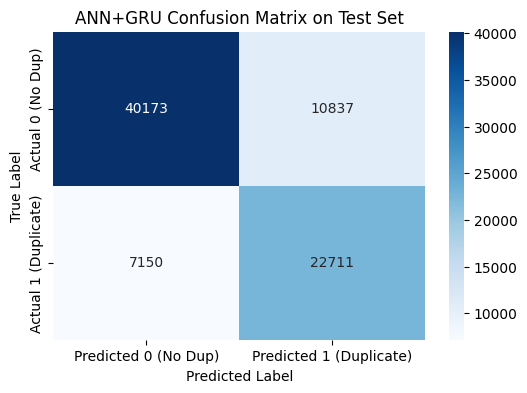

Saved: evaluation_confusion_matrix.png

--- Plotting AUC-ROC Curve ---


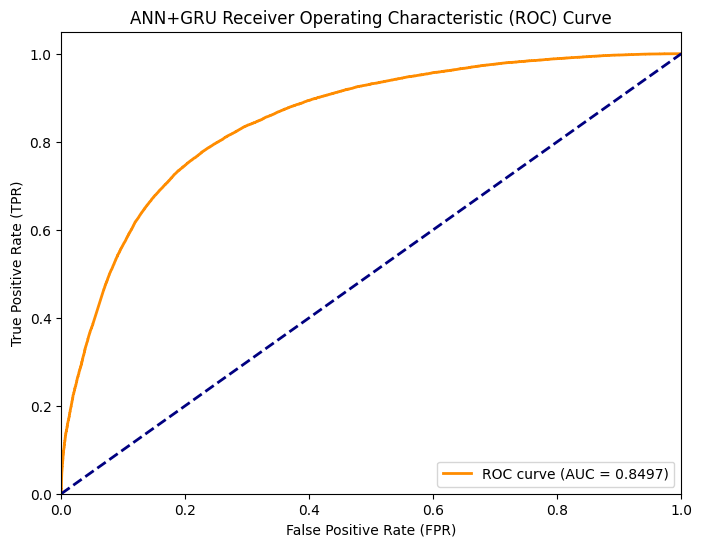

Saved: evaluation_roc_curve.png

Evaluation complete. Your final performance metrics are reported above.


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


print("--- Generating Predictions on Test Set ---")


y_test_proba = siamese_model_GRU.predict(
    {'input_q1': X_test_q1, 'input_q2': X_test_q2}
).flatten()


y_test_pred = (y_test_proba > 0.5).astype(int)


print("\n--- Final Classification Metrics on Test Set ---")

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f} <--- PRIMARY METRIC")
print(f"AUC-ROC:   {auc_roc:.4f}")


print("\n--- Plotting Confusion Matrix ---")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No Dup)', 'Predicted 1 (Duplicate)'],
            yticklabels=['Actual 0 (No Dup)', 'Actual 1 (Duplicate)'])
plt.title('ANN+GRU Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('evaluation_confusion_matrix.png')
plt.show()
plt.close()
print("Saved: evaluation_confusion_matrix.png")


print("\n--- Plotting AUC-ROC Curve ---")

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ANN+GRU Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('evaluation_roc_curve.png')
plt.show()
plt.close()
print("Saved: evaluation_roc_curve.png")

print("\nEvaluation complete. Your final performance metrics are reported above.")